In [0]:
!tar zxvf UTKFace.tar.gz 

UTKFace/82_0_2_20170111210110290.jpg.chip.jpg
UTKFace/32_1_2_20170116180211518.jpg.chip.jpg
UTKFace/21_0_4_20170103225103768.jpg.chip.jpg
UTKFace/27_1_2_20170116171716287.jpg.chip.jpg
UTKFace/26_0_4_20170117153355923.jpg.chip.jpg
UTKFace/26_1_0_20170116231512359.jpg.chip.jpg
UTKFace/54_0_3_20170119211308521.jpg.chip.jpg
UTKFace/25_1_1_20170112235005249.jpg.chip.jpg
UTKFace/4_1_2_20161219211452533.jpg.chip.jpg
UTKFace/16_0_0_20170110232647979.jpg.chip.jpg
UTKFace/26_1_0_20170119192623081.jpg.chip.jpg
UTKFace/26_1_1_20170116170028717.jpg.chip.jpg
UTKFace/26_1_2_20170116180214166.jpg.chip.jpg
UTKFace/28_0_4_20170116220531686.jpg.chip.jpg
UTKFace/29_1_4_20170103230245713.jpg.chip.jpg
UTKFace/40_0_0_20170104204609691.jpg.chip.jpg
UTKFace/26_1_1_20170116160930991.jpg.chip.jpg
UTKFace/26_1_3_20170117153712926.jpg.chip.jpg
UTKFace/30_1_4_20170103183855083.jpg.chip.jpg
UTKFace/26_0_2_20170116175433114.jpg.chip.jpg
UTKFace/8_1_0_20170109204954253.jpg.chip.jpg
UTKFace/27_0_2_20161219192534211.jpg

In [0]:
!pip install tensorflow-gpu==2.0.0b1

In [0]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm 
from random import shuffle
import gc
import cv2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Activation, Input, Flatten
from tensorflow.keras.optimizers import Adam
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score, mean_squared_error

imageDir = "UTKFace/"
IMG_SIZE = 160

tf.__version__

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

'2.0.0-beta1'

In [0]:
imgs = os.listdir(imageDir)
imgs[:3], len(imgs)

(['26_0_0_20170104172735675.jpg.chip.jpg',
  '50_0_0_20170117144652339.jpg.chip.jpg',
  '24_1_3_20170119155454786.jpg.chip.jpg'],
 23708)

In [0]:
imgs[0].split('_')[0], imgs[0].split('_')[1], imgs[0].split('_')[2]

('26', '0', '0')

In [0]:
def preprocessing(imageDir):
    #imgs = []
    #ages = []
    #genders = []
    #ethnics = []
    data = []
    for filename in tqdm(os.listdir(imageDir)):
        if len(filename.split('_')) == 4:      
          img = cv2.imread(os.path.join(imageDir + filename))
          img = cv2.resize(img, (IMG_SIZE,IMG_SIZE)).astype('float32')
          img = img.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
          img = img/255.
          age = float(filename.split('_')[0])
          age = age/106.
          gender = int(filename.split('_')[1])
          ethnic = int(filename.split('_')[2])
          data.append([img, age, gender, ethnic])
          del filename
        #imgs.append(img)
        #ages.append(age)
        #genders.append(gender)
        #ethnics.append(ethnic)
    data = np.array(data)
    shuffle(data)
    imgs = data[:,0]
    ages = np.array(data[:,1]).astype('float')
    genders = np.array(data[:,2]).astype('float')
    ethnics = np.array(data[:,3]).astype('float')
    gc.collect()
    return imgs, ages, genders, ethnics 

In [0]:
def agemodel(inputs, numAges):
    x = Dense(256)(inputs)
    x = LeakyReLU()(x)
    x = Dropout(0.1)(x)
    x = Dense(128)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.1)(x)
    x = Dense(1)(x)
    x = Activation('sigmoid', name='ageoutput')(x)
    return x

In [0]:
def gendermodel(inputs, numGenders):
    x = Dense(64)(inputs)
    x = LeakyReLU()(x)
    x = Dropout(0.1)(x)
    x = Dense(32)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.1)(x)
    x = Dense(numGenders)(x)
    x = Activation('softmax', name='genderoutput')(x)
    return x

In [0]:
def ethnicmodel(inputs, numEthnics):
    x = Dense(64)(inputs)
    x = LeakyReLU()(x)
    x = Dropout(0.1)(x)
    x = Dense(32)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.1)(x)
    x = Dense(numEthnics)(x)
    x = Activation('softmax', name='ethnicoutput')(x)
    return x

In [0]:
imgs, ages, genders, ethnics = preprocessing(imageDir)

100%|██████████| 23708/23708 [00:23<00:00, 1019.24it/s]


In [0]:
imgs = np.array([img for img in imgs])

In [0]:
imgs = imgs.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [0]:
type(imgs), imgs.shape

(numpy.ndarray, (23705, 160, 160, 3))

In [0]:
numAges = len(np.unique(ages))
numAges, type(ages), ages[100:115], ages.shape

(102,
 numpy.ndarray,
 array([0.21698113, 0.19811321, 0.23584906, 0.80188679, 0.00943396,
        0.23584906, 0.53773585, 0.30188679, 0.64150943, 0.75471698,
        0.51886792, 0.16981132, 0.64150943, 0.37735849, 0.24528302]),
 (23705,))

In [0]:
numGenders = len(np.unique(genders))
numGenders, type(genders), genders[100:115]

(2,
 numpy.ndarray,
 array([0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1.]))

In [0]:
numEthnics = len(np.unique(ethnics))
numEthnics, type(ethnics), ethnics[100:115]

(5,
 numpy.ndarray,
 array([0., 4., 3., 0., 3., 2., 0., 0., 1., 0., 0., 3., 0., 2., 3.]))

In [0]:
model_path = 'facenet_keras.h5'
face_model = load_model(model_path)

face_model.trainable = False

In [0]:
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = face_model(inputs)
#x = Flatten()(x)
x = Dense(128)(x)
#x = LeakyReLU()(x)
#x = Dropout(0.2)(x)
x = Dense(128)(x)
x = LeakyReLU()(x)
ageBranch = agemodel(x, numAges)
genderBranch = gendermodel(x, numGenders)
ethnicBranch = ethnicmodel(x, numEthnics)

model = Model(inputs=inputs, outputs=[ageBranch, genderBranch, ethnicBranch])


In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
inception_resnet_v1 (Model)     (None, 128)          22808144    input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          16512       inception_resnet_v1[1][0]        
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
______________________________________________________________________________________________

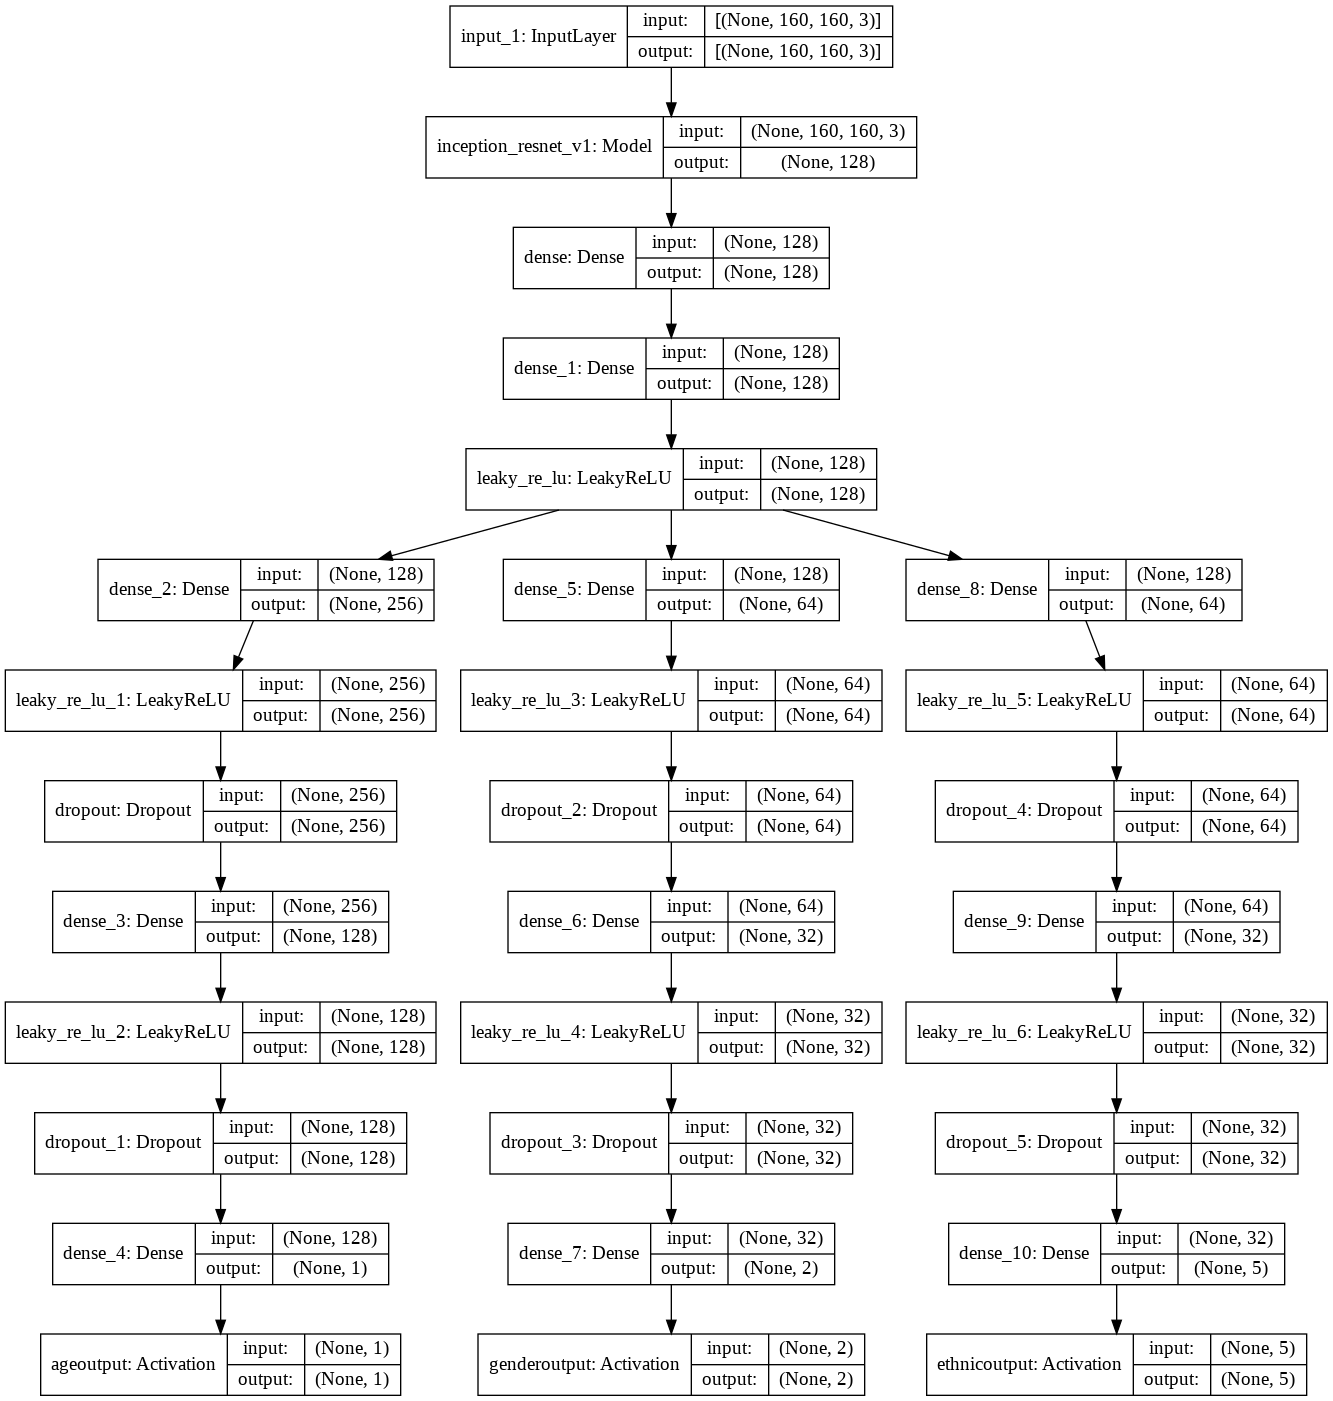

In [0]:
from tensorflow import keras
keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [0]:
#gc.collect()

In [0]:
model.compile(optimizer='adam' ,
              loss={'ageoutput': 'mse', 'genderoutput': 'sparse_categorical_crossentropy', 'ethnicoutput': 'sparse_categorical_crossentropy'},
              loss_weights={'ageoutput': 2., 'genderoutput': 1. , 'ethnicoutput': 1.5},
              metrics={'ageoutput': 'mae', 'genderoutput': 'sparse_categorical_accuracy', 'ethnicoutput': 'sparse_categorical_accuracy'})

In [0]:
gc.collect()

3283

In [0]:
X_train, X_test, agetrain, agetest, gendertrain, gendertest, ethnictrain, ethnictest = train_test_split(imgs, ages, genders, ethnics, test_size=0.2, random_state=42)

In [0]:
EPOCHS = 20
model.fit(X_train, 
          {'ageoutput':agetrain, 'genderoutput':gendertrain, 'ethnicoutput':ethnictrain},
          epochs=EPOCHS,
          validation_split=0.2, batch_size=16)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 15171 samples, validate on 3793 samples
Epoch 1/20
15171/15171 [==============================] - 71s 5ms/sample - loss: 1.4011 - ageoutput_loss: 0.0131 - genderoutput_loss: 0.3382 - ethnicoutput_loss: 0.6912 - ageoutput_mae: 0.0861 - genderoutput_sparse_categorical_accuracy: 0.8500 - ethnicoutput_sparse_categorical_accuracy: 0.7692 - val_loss: 1.3353 - val_ageoutput_loss: 0.0098 - val_genderoutput_loss: 0.2678 - val_ethnicoutput_loss: 0.6952 - val_ageoutput_mae: 0.0752 - val_genderoutput_sparse_categorical_accuracy: 0.8787 - val_ethnicoutput_sparse_categorical_accuracy: 0.7735
Epoch 2/20
15171/15171 [==============================] - 55s 4ms/sample - loss: 1.1812 - ageoutput_loss: 0.0098 - genderoutput_loss: 0.2550 - ethnicoutput_loss: 0.6042 - ageoutput_mae: 0.0737 - genderoutput_sparse_categorical_accuracy: 0.8947 - ethnicoutput_sparse_categorical_accuracy: 0.7995 - val_loss: 1.388

In [0]:
gc.collect()

24

In [0]:
agepred, genderpred, ethnicpred = model.predict(X_test)

In [0]:
agepred, genderpred, ethnicpred

(array([[0.4693184 ],
        [0.19872901],
        [0.00980589],
        ...,
        [0.26526138],
        [0.24336019],
        [0.27823594]], dtype=float32), array([[0.9989405 , 0.00105944],
        [0.44213498, 0.55786496],
        [0.5785014 , 0.42149857],
        ...,
        [0.9906151 , 0.00938489],
        [0.9835792 , 0.0164207 ],
        [0.9733128 , 0.02668723]], dtype=float32), array([[1.3463867e-01, 7.4681592e-01, 5.1343154e-02, 5.3130127e-02,
         1.4072133e-02],
        [9.1640258e-01, 3.1065468e-03, 3.5821819e-03, 1.5144418e-02,
         6.1764318e-02],
        [6.9938052e-01, 3.8266627e-03, 6.3980550e-02, 3.1822570e-02,
         2.0098975e-01],
        ...,
        [4.6204166e-03, 4.6257666e-04, 9.8610920e-01, 2.2632475e-03,
         6.5445569e-03],
        [6.8954860e-06, 9.9999237e-01, 2.8793042e-07, 7.5638191e-08,
         3.7332745e-07],
        [1.1916511e-03, 9.9509478e-01, 4.1096304e-05, 2.9533899e-03,
         7.1913650e-04]], dtype=float32))

In [0]:
agepred, agepred.shape

(array([[0.4693184 ],
        [0.19872901],
        [0.00980589],
        ...,
        [0.26526138],
        [0.24336019],
        [0.27823594]], dtype=float32), (4741, 1))

In [0]:
agetest, agetest.shape

(array([0.37735849, 0.1509434 , 0.00943396, ..., 0.25471698, 0.26415094,
        0.26415094]), (4741,))

In [0]:
agemse = mean_squared_error(agetest, agepred)
agemse

0.007840296823665457

In [0]:
genderpred = [np.argmax(gender) for gender in genderpred]

[0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,


In [0]:
genderacc = accuracy_score(gendertest, genderpred)
genderacc

0.9071925754060325

In [0]:
gendermse = mean_squared_error(gendertest, genderpred)
gendermse

0.09280742459396751

In [0]:
ethnicpred = [np.argmax(ethnic) for ethnic in ethnicpred]

In [0]:
ethnicacc = accuracy_score(ethnictest, ethnicpred)
ethnicacc

0.7783168107994094

In [0]:
ethnicmse = mean_squared_error(ethnictest, ethnicpred)
ethnicmse

1.4885045349082473

In [0]:
imgtest = cv2.imread('16_0_2test.jpg')
imgtest = cv2.resize(imgtest, (IMG_SIZE,IMG_SIZE)).astype('float32')
imgtest = imgtest.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
imgtest = imgtest/255.

In [0]:
age, gender, ethnic = model.predict(imgtest)

In [0]:
age, gender, ethnic

(array([[0.39057732]], dtype=float32),
 array([[0.01182484, 0.98817515]], dtype=float32),
 array([[9.5129651e-01, 1.9623561e-02, 3.3590732e-06, 1.8302327e-03,
         2.7246254e-02]], dtype=float32))

In [0]:
age = int(age.reshape(-1,)[0]*106)
age

41

In [0]:
gender = np.argmax(gender[0])
gender

1

In [0]:
ethnic = np.argmax(ethnic[0])
ethnic

0